In [1]:
import os, random, cv2, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from PIL import Image
import matplotlib.pyplot as plt5
import tensorflow as tf
from tensorflow.keras.models import load_model

In [2]:
# load the model
model = load_model('../input/face-net-keras-model/facenet_keras.h5', compile= False)

img_paths=glob.glob('../input/facedataset/ORL_jpg/ORL_jpg/ORL_jpg/*/*.jpg')
len(img_paths), img_paths[:3]

(400,
 ['../input/facedataset/ORL_jpg/ORL_jpg/ORL_jpg/s32/p32c8.jpg',
  '../input/facedataset/ORL_jpg/ORL_jpg/ORL_jpg/s32/p32c9.jpg',
  '../input/facedataset/ORL_jpg/ORL_jpg/ORL_jpg/s32/p32c10.jpg'])

In [3]:
%mkdir Templates
%mkdir RDM-Templates

def load_img(path, resize=None):
    img= Image.open(path)
    img= img.convert('RGB')
    if resize is not None:
        img= img.resize((resize, resize))
    return np.asarray(img)

In [4]:
Templates_dic= {'img':[], 'label':[]}
for path in img_paths:
    Dir= ('Templates/'+path.split('/')[-2])
    os.makedirs(('Templates/'+path.split('/')[-2]), exist_ok=True)
    img= load_img(path, resize=160)
    img= img[np.newaxis, :, :, :]/255.0
    feature= model.predict(img)
    Templates_dic['img'].append(feature)
    Templates_dic['label'].append(path.split('/')[-2])
    np.save((Dir+ '/'+ path.split('/')[-1][:-4]+'.npy'), feature)
    

In [5]:
def salt_2dim(X):
    samples, features= X.shape
    X_out= np.zeros((samples,features//2, 2))
    for i, x in enumerate(X):
        X_out[i,:, 0]= x[:features//2]
        X_out[i,:, 1]= x[features//2:]
    return X_out

def shuffle(X_vec, p=4, seed= 0, with_seed= True):
    for X in X_vec:
        j= 64+p
        for i in np.arange(p, j, p):
            x= X[(i-p):i]
            if with_seed:
                np.random.seed(seed)
            np.random.shuffle(x[:8])
    return X_vec

def get_RDM(Fv, token=None, c=100):
    '''
    INPUT---
    Fv.shape: (None, feature)
    token: Uses token key
    PROCESS---
    1. Feature vector(Fv) multiplied by a large constant, say c = 100 due to its low dynamic range.
    2. To increase the entropy of the template, fv is salted by ORing it with a random grid RG as fs = fv + RG.
    3. Fv is divided into two equal parts.
    4. A user-specific key (K) of dimension 1 × N is generated, 
    which has randomly distributed non-integral values in the range [−100, 100].
    5. Computation of distance via random feature vectors.
    6. In order to provide noninvertibility, median filtering is applied on distance vector D
    to generate transformed feature vector T f , where the intensity
    values are shuffled in p ×1 neighborhood. T f is stored as the
    final transformed template.
    OUTPUT---
    Out.shape: (None, feature//2)
    '''
    #1
    #Fv*= c
    #2
    np.random.seed(token)
    Fv+= np.random.randint(1, 256, size= Fv.shape)
    #3
    Fv= salt_2dim(Fv)
    #4
    np.random.seed(token)
    K= np.random.randint(-100, 101, size= (1, Fv.shape[-1]))
    #5
    dist =(Fv- K)**2
    dist= np.sqrt(np.sum(dist, 2))
    #6
    Tf= shuffle(dist.copy(), p=4, seed= token, with_seed= True)
    return Tf

In [6]:
RDM_Templates_dic= {'img':[], 'label':[]}
for path in img_paths:
    Dir= ('RDM-Templates/'+path.split('/')[-2])
    os.makedirs(('RDM-Templates/'+path.split('/')[-2]), exist_ok=True)
    img= load_img(path, resize=160)
    img= img[np.newaxis, :, :, :]/255.0
    feature= model.predict(img)
    
    #RDM
    token= int(path.split('/')[-2][1:])
    feature_rdm= get_RDM(feature.copy(), token= token)
    #print(feature[0, :5], feature_rdm[0, :5])
    RDM_Templates_dic['img'].append(feature_rdm)
    RDM_Templates_dic['label'].append(path.split('/')[-2])
    np.save((Dir+ '/'+ path.split('/')[-1][:-4]+'.npy'), feature_rdm)

In [7]:
print(np.array(RDM_Templates_dic['img']).shape, np.array(Templates_dic['img']).shape)
RDM_Templates_array= np.array(RDM_Templates_dic['img'])[:, 0, :]
Templates_array= np.array(Templates_dic['img'])[:, 0, :]
print(np.array(RDM_Templates_array).shape, np.array(Templates_array).shape)

print('RDM Feature Scale {} -> {}'.format(RDM_Templates_array.min(), RDM_Templates_array.max()))
print('Normal Feature Scale {} -> {}'.format(Templates_array.min(), Templates_array.max()))

(400, 1, 64) (400, 1, 128)
(400, 64) (400, 128)
RDM Feature Scale 5.2238497191107935 -> 493.6830147636853
Normal Feature Scale -4.255441665649414 -> 4.28276252746582


In [8]:
Templates_array= (Templates_array- Templates_array.min())/(Templates_array.max()- Templates_array.min())
RDM_Templates_array= (RDM_Templates_array- RDM_Templates_array.min())/(RDM_Templates_array.max()- RDM_Templates_array.min())

print('RDM Feature Scale {} -> {}'.format(RDM_Templates_array.min(), RDM_Templates_array.max()))
print('Normal Feature Scale {} -> {}'.format(Templates_array.min(), Templates_array.max()))

RDM Feature Scale 0.0 -> 1.0
Normal Feature Scale 0.0 -> 1.0


In [9]:
def convert_pca(x, ret= False):
    pca= PCA(n_components=2)
    x= pca.fit_transform(x)
    if ret:
        return pca, x
    return x

In [10]:
pca_rdm, PCA_RDM_Temp= convert_pca(RDM_Templates_array, ret= True)
pca, PCA_Temp= convert_pca(Templates_array, ret= True)

print('RDM Feature Scale {} -> {}'.format(PCA_RDM_Temp.min(), PCA_RDM_Temp.max()))
print('Normal Feature Scale {} -> {}'.format(PCA_Temp.min(), PCA_Temp.max()))

RDM Feature Scale -1.5636843223407249 -> 2.1485004245392925
Normal Feature Scale -0.8361366391181946 -> 1.0366393327713013


In [11]:
subject=[]
for path in img_paths:
    if path.split('/')[-2] not in subject:
        subject.append(path.split('/')[-2])
len(subject)

40

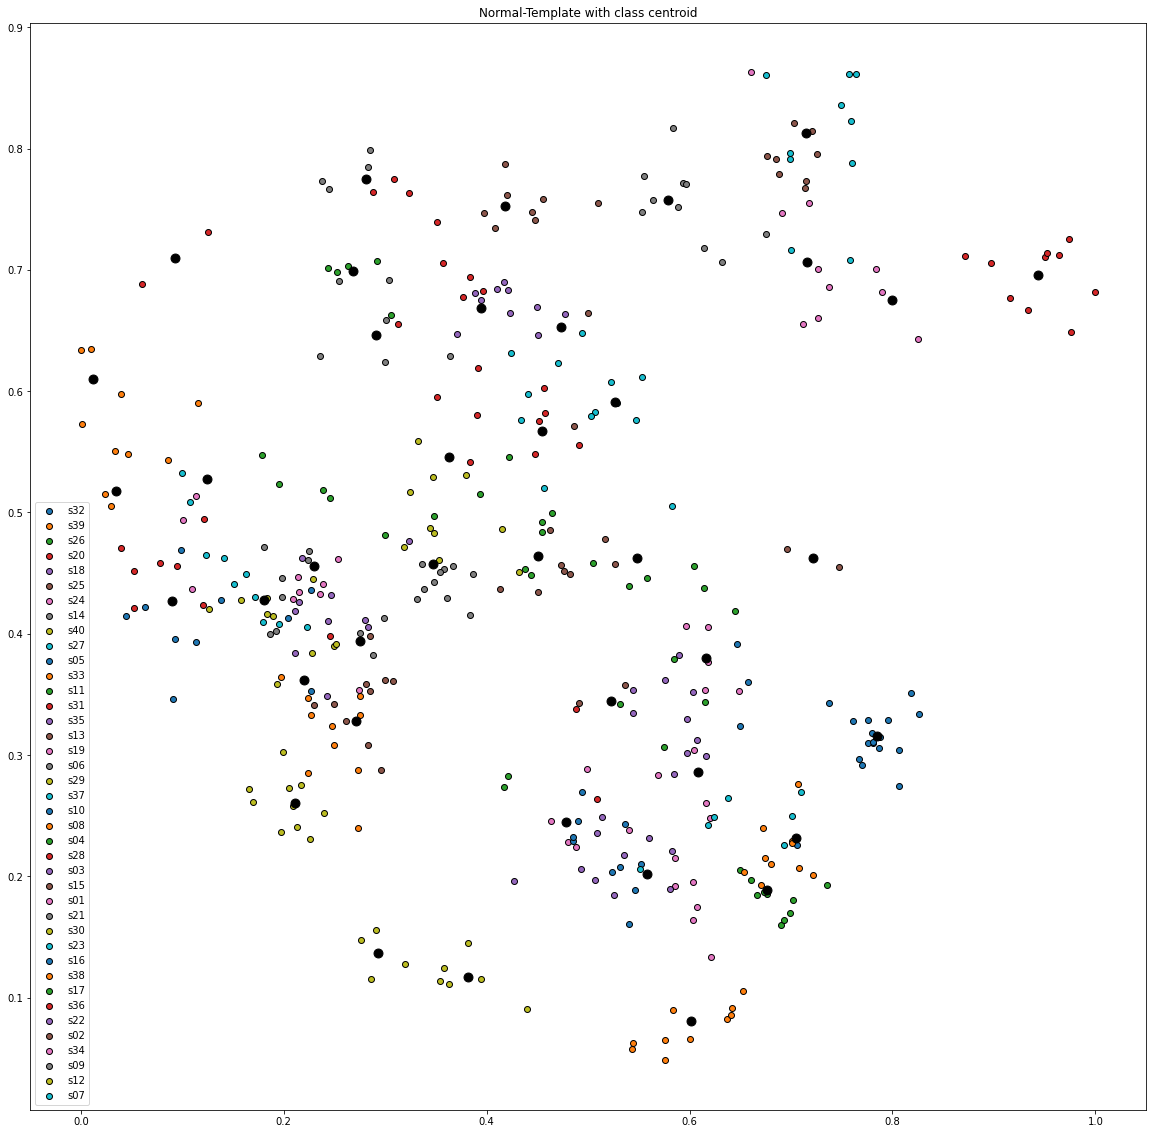

In [12]:
#scaling (0-1)
PCA_Temp= (PCA_Temp- PCA_Temp.min())/(PCA_Temp.max()- PCA_Temp.min())

#Initialize the class object
kmeans = KMeans(n_clusters= 40)
#predict the labels of clusters.
label = kmeans.fit_predict(PCA_Temp)
#Getting the Centroids
centroids = kmeans.cluster_centers_

plt.figure(figsize= (20, 20))
for i in range(40):
    plt.scatter(PCA_Temp[i*10:(i+1)*10, 0], PCA_Temp[i*10:(i+1)*10, 1], edgecolors='k', label=subject[i])
    plt.legend()
    
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.title('Normal-Template with class centroid')
plt.show()

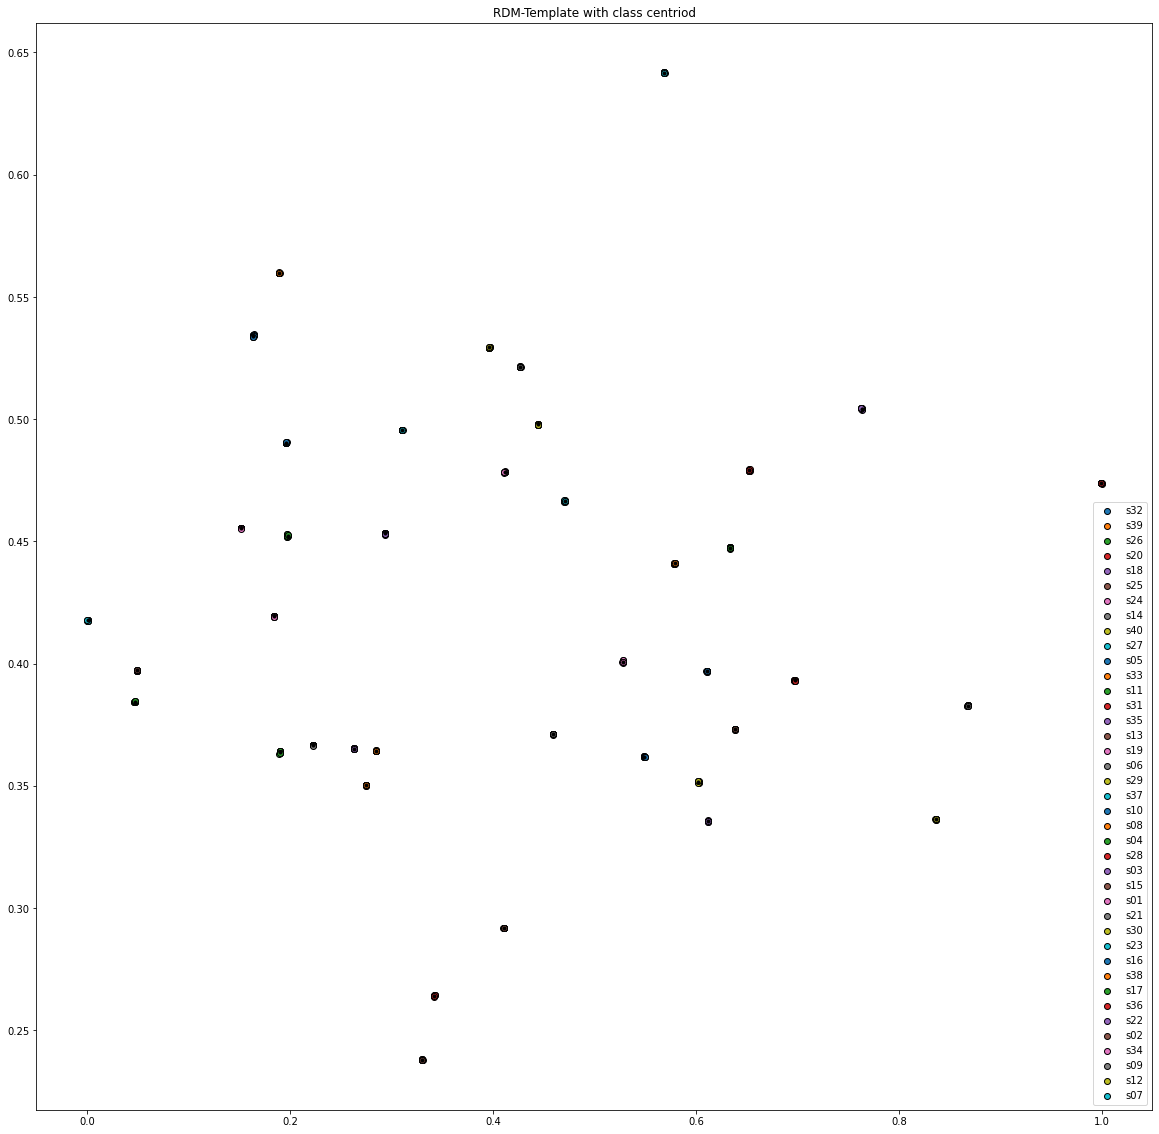

In [13]:
#scaling (0-1)
PCA_RDM_Temp= (PCA_RDM_Temp- PCA_RDM_Temp.min())/(PCA_RDM_Temp.max()- PCA_RDM_Temp.min())

#Initialize the class object
kmeans = KMeans(n_clusters= 40)
#predict the labels of clusters.
label = kmeans.fit_predict(PCA_RDM_Temp)
#Getting the Centroids
centroids = kmeans.cluster_centers_

plt.figure(figsize= (20, 20))
for i in range(40):
    plt.scatter(PCA_RDM_Temp[i*10:(i+1)*10, 0], PCA_RDM_Temp[i*10:(i+1)*10, 1], edgecolors='k', label=subject[i])
    plt.legend()
    
plt.scatter(centroids[:,0] , centroids[:,1] , s = 10, color = 'k')
plt.title('RDM-Template with class centriod')
plt.show()

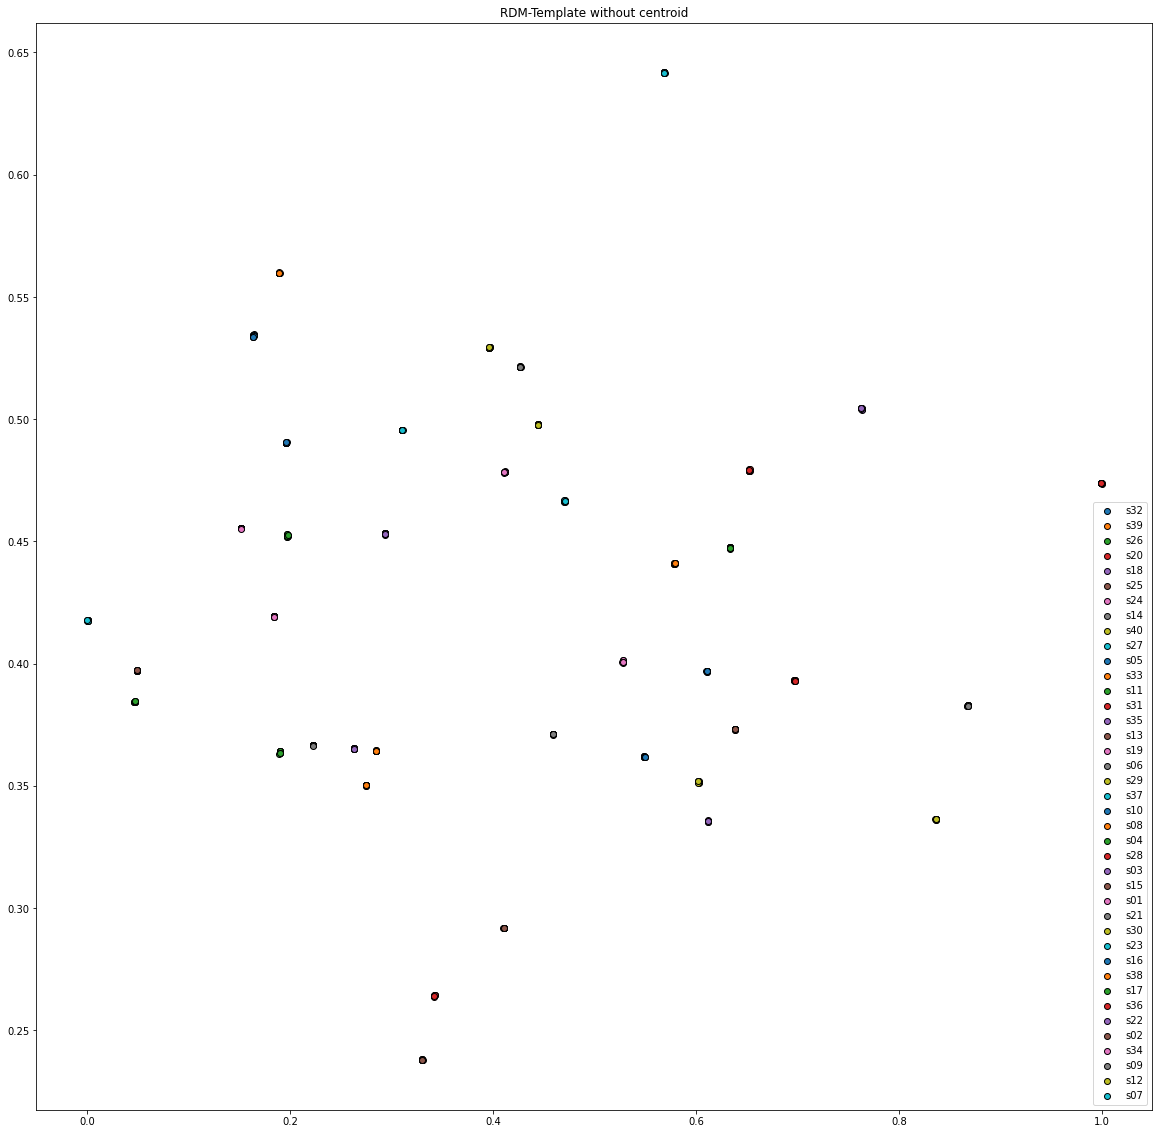

In [14]:
plt.figure(figsize= (20, 20))
for i in range(40):
    plt.scatter(PCA_RDM_Temp[i*10:(i+1)*10, 0], PCA_RDM_Temp[i*10:(i+1)*10, 1], edgecolors='k', label=subject[i])
    plt.legend()
plt.title('RDM-Template without centroid')
plt.show()

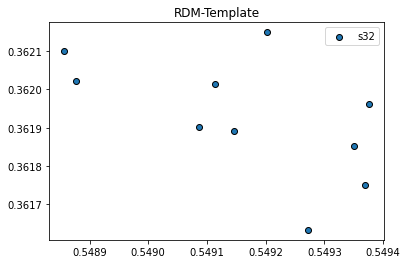

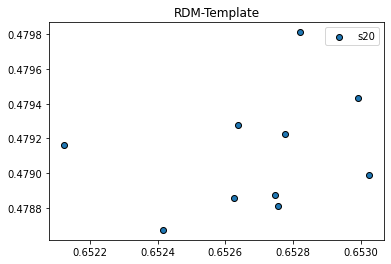

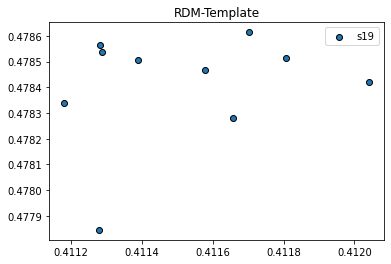

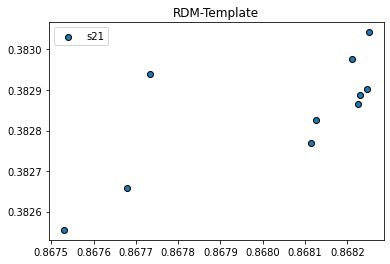

In [15]:
i= 0
plt.scatter(PCA_RDM_Temp[i*10:(i+1)*10, 0], PCA_RDM_Temp[i*10:(i+1)*10, 1], edgecolors='k', label=subject[i])
plt.legend()
plt.title('RDM-Template')
plt.show()

i=3
plt.scatter(PCA_RDM_Temp[i*10:(i+1)*10, 0], PCA_RDM_Temp[i*10:(i+1)*10, 1], edgecolors='k', label=subject[i])
plt.legend()
plt.title('RDM-Template')
plt.show()

i=16
plt.scatter(PCA_RDM_Temp[i*10:(i+1)*10, 0], PCA_RDM_Temp[i*10:(i+1)*10, 1], edgecolors='k', label=subject[i])
plt.legend()
plt.title('RDM-Template')
plt.show()

i=27
plt.scatter(PCA_RDM_Temp[i*10:(i+1)*10, 0], PCA_RDM_Temp[i*10:(i+1)*10, 1], edgecolors='k', label=subject[i])
plt.legend()
plt.title('RDM-Template')
plt.show()

In [16]:
np.save('RDM_Templates_array.npy', RDM_Templates_array)
np.save('Templates_array.npy', Templates_array)

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import plot_confusion_matrix

In [18]:
le = preprocessing.LabelEncoder()
le.fit(Templates_dic['label'])
print(list(le.classes_))

['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's40']


In [19]:
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(Templates_array,
                                    le.transform(Templates_dic['label']), random_state = 32, test_size=0.2)

#pd.Series(y_test).value_counts()

In [20]:
# training a linear SVM classifier
from sklearn.svm import SVC
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
svm_predictions = svm_model_linear.predict(X_test)

# model accuracy for X_test  
accuracy = svm_model_linear.score(X_test, y_test)
accuracy

0.975

In [21]:
le = preprocessing.LabelEncoder()
le.fit(RDM_Templates_dic['label'])
print(list(le.classes_))

['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's40']


In [22]:
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(RDM_Templates_array,
                                    le.transform(RDM_Templates_dic['label']), random_state = 32, test_size=0.2)

#pd.Series(y_test).value_counts()

In [23]:
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(RDM_Templates_array,
                                    le.transform(RDM_Templates_dic['label']), random_state = 32, test_size=0.2)

#pd.Series(y_test).value_counts()
# training a linear SVM classifier
from sklearn.svm import SVC
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
svm_predictions = svm_model_linear.predict(X_test)

# model accuracy for X_test  
accuracy = svm_model_linear.score(X_test, y_test)
accuracy

1.0